In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [3]:
# load the already done pca on the dataset
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

In [5]:
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix,roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score,plot_roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Exploratory Data Analysis

In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# checking for NAN values
data.isnull().values.any()

False

In [8]:
# plot bar graph showing the distribution of anmomolous to non-anomolous transactions
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes
# got  - 492 fraud trnasactions

0    284315
1       492
Name: Class, dtype: int64

<BarContainer object of 2 artists>

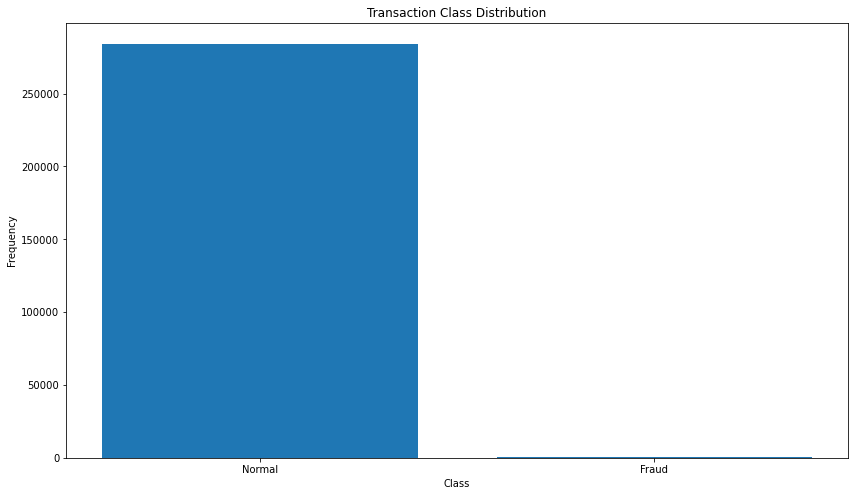

In [9]:
names = ["Normal","Fraud"]
values = count_classes
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(names,values)

In [10]:
# separating the fraud and normal data
normal = data[data['Class']==0]
fraud = data[data['Class']==1]
print(normal.shape)
print(fraud.shape)

(284315, 31)
(492, 31)


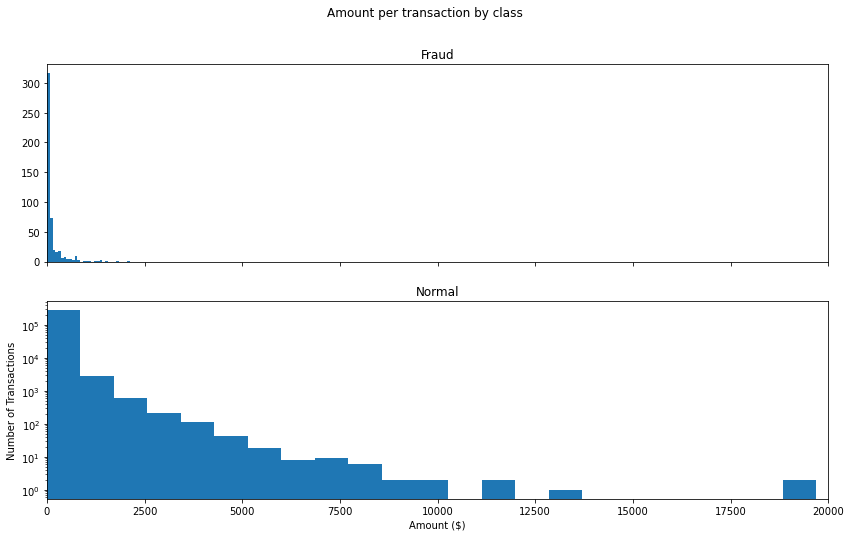

In [11]:
# Amount per transaction distrbution
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 30
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

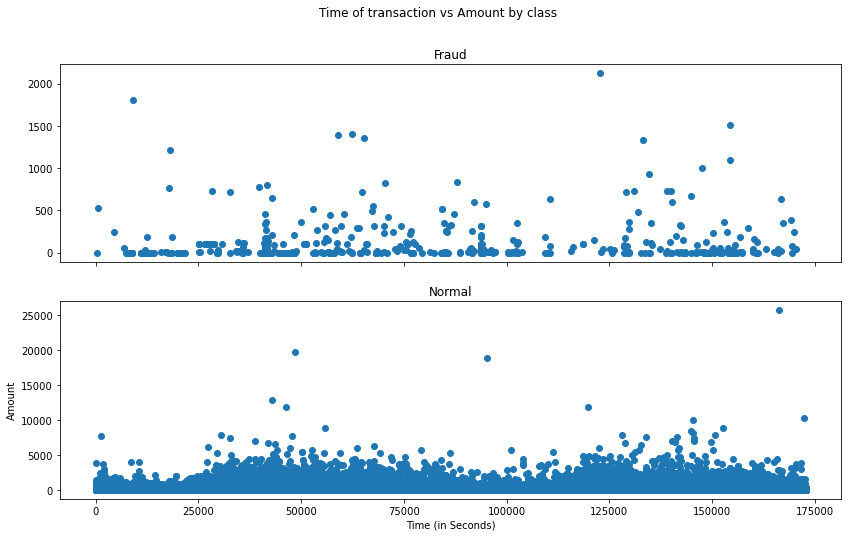

In [12]:
# time of trnasaction vs amount by class
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

From the second plot, we can observe that fraudulent transactions occur at the same time as normal transaction, making time an irrelevant factor. From the first plot, we can see that most of the fraudulent transactions are small amount transactions. This is however not a huge differentiating feature since majority of normal transactions are also small amount transactions.

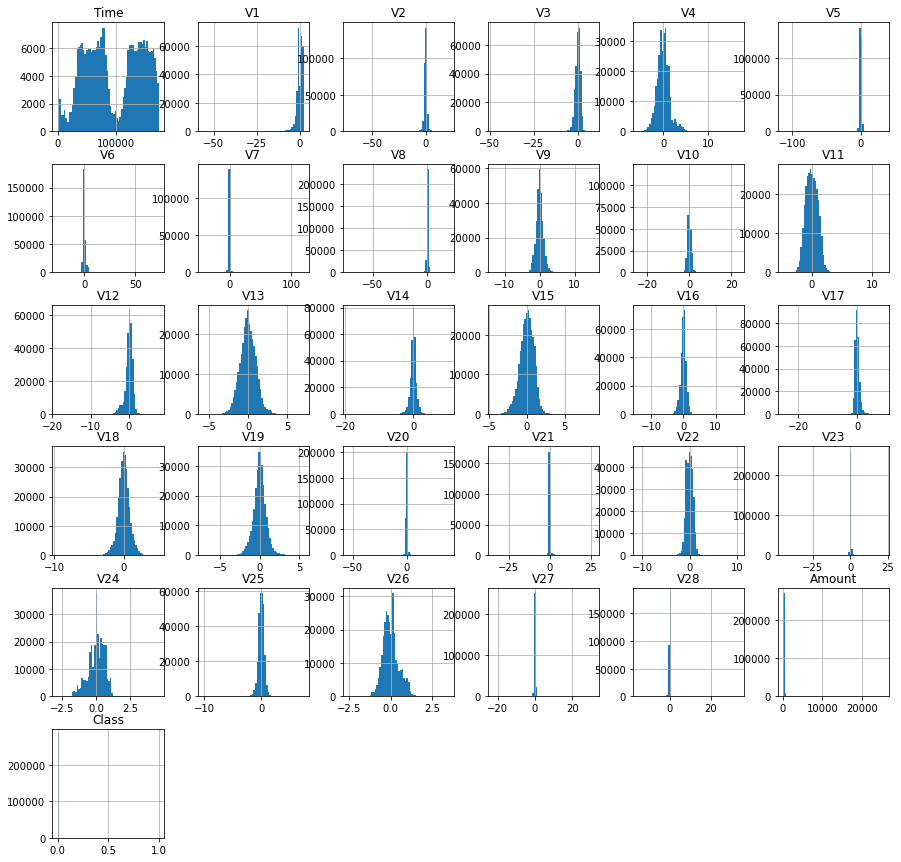

In [13]:
data.hist(figsize=(15,15), bins = 64)
plt.show()

In [14]:
#data.drop(['Time', 'V1', 'V24'], axis=1, inplace=True)
data.drop(['Time', 'V24'], axis=1, inplace=True)

In [26]:
# lets reduce our dataset to say 30% as it is a huge dataset with more than 284k+ objects
df= data.sample(frac = 0.3,random_state=1)
df.shape

(85442, 29)

In [27]:
data.shape
# you see the difference , original data had 284k examples while the reduced have 85k

(284807, 29)

In [28]:
# now lets see the distribution again of normal vs fraud transaction
Fraud = df[df['Class']==1]
Normal = df[df['Class']==0]
print(Fraud.shape,Normal.shape)
# you see about 135 fraud cases now

(135, 29) (85307, 29)


We have just 0.16% fraudulent transactions in the dataset. This means that a random guess by the model should yield 0.16% accuracy for fraudulent transactions

In [29]:
outlier_fraction = len(Fraud)/float(len(Normal))
outlier_fraction 

0.001582519605659559

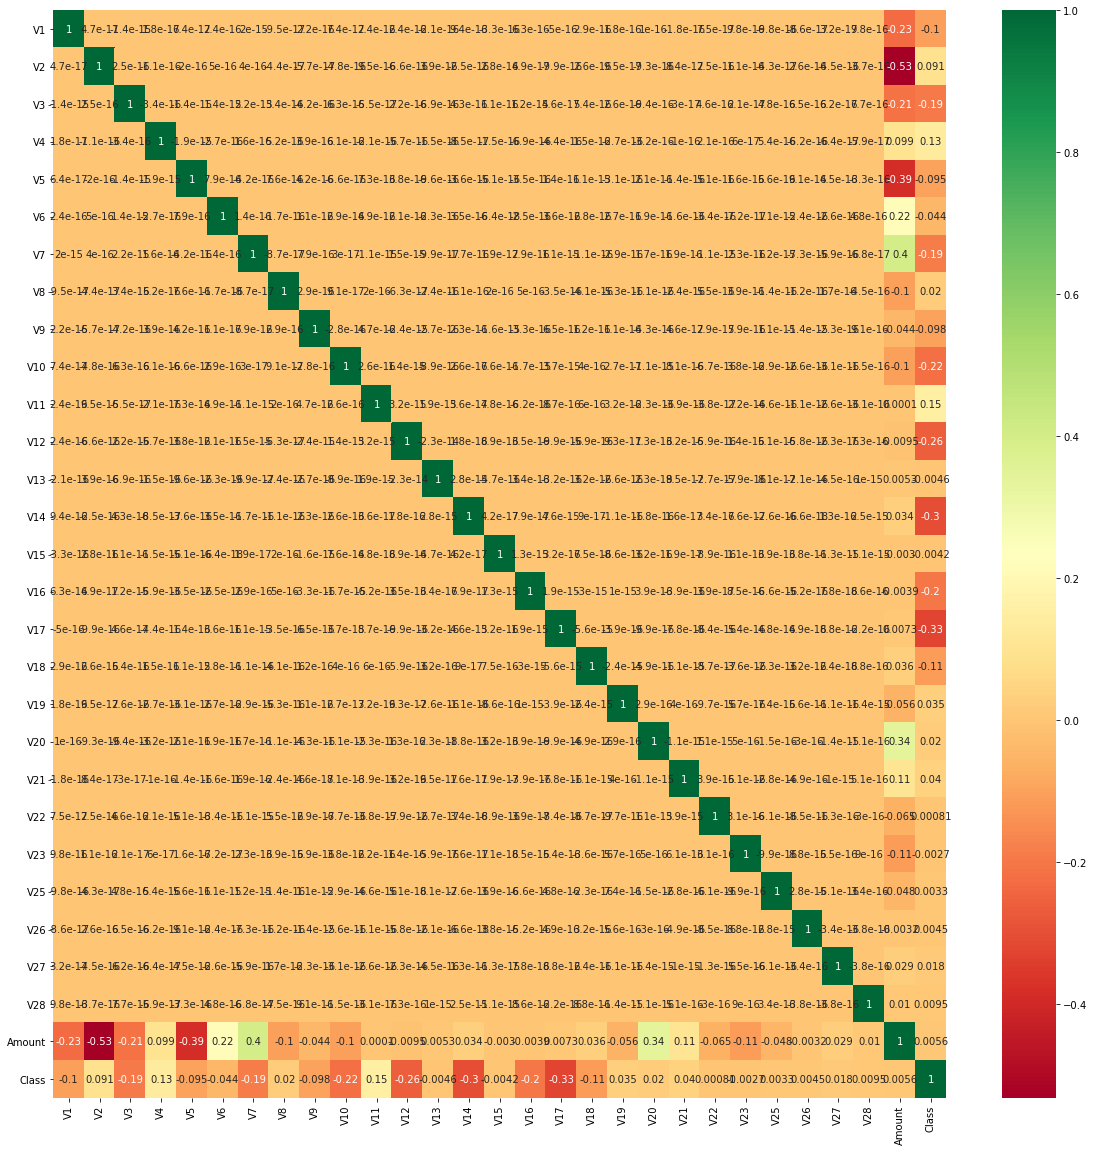

In [30]:
#Correlation using heatmap
import seaborn as sns
#get correlations of each features in dataset
corrmat =df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Building Models and Model Prediction

In [31]:
#Create independent and Dependent Features
columns = df.columns.tolist()  # all columns
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]   # removing "Class" from our columns list
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(85442, 28)
(85442,)


In [32]:
# Train_test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [33]:
print(y_test)

56237     0
66869     0
172144    0
1492      0
166630    0
         ..
207926    0
214368    0
41937     0
91143     0
175396    0
Name: Class, Length: 28196, dtype: int64


# Plotting Functions - ROC and Confusion Matrix

In [34]:
import itertools
classes = np.array(['0','1'])
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
#plotting roc curve
def plot_roc(y_test,preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [36]:
predicts = {}

## Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

## Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [ ]:
n_outliers = len(Fraud)
n_outliers

## Local Outlier factor

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski',p=2, metric_params=None, contamination=outlier_fraction)
y_train_pred = clf.fit_predict(X_train)
#print(y_pred)
scores_prediction = clf.negative_outlier_factor_
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

# on test data
y_test_pred = clf.fit_predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])


In [ ]:
print('Total fraudulent transactions detected in training set: ' + str(cm_train[1][1]) + ' / ' + str(cm_train[1][1]+cm_train[1][0]))
print('Total non-fraudulent transactions detected in training set: ' + str(cm_train[0][0]) + ' / ' + str(cm_train[0][1]+cm_train[0][0]))

print('Probability to detect a fraudulent transaction in the training set: ' + str(cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])))
print('Probability to detect a non-fraudulent transaction in the training set: ' + str(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])))

print("Accuracy of unsupervised anomaly detection model on the training set: "+str(100*(cm_train[0][0]+cm_train[1][1]) / (sum(cm_train[0]) + sum(cm_train[1]))) + "%")

In [ ]:
cm_test = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in test set: ' + str(cm_test[1][1]) + ' / ' + str(cm_test[1][1]+cm_test[1][0]))
print('Total non-fraudulent transactions detected in test set: ' + str(cm_test[0][0]) + ' / ' + str(cm_test[0][1]+cm_test[0][0]))

print('Probability to detect a fraudulent transaction in the test set: ' + str(cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])))
print('Probability to detect a non-fraudulent transaction in the test set: ' + str(cm_test[0][0]/(cm_test[0][1]+cm_test[0][0])))

print("Accuracy of unsupervised anomaly detection model on the test set: "+str(100*(cm_test[0][0]+cm_test[1][1]) / (sum(cm_test[0]) + sum(cm_test[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_test_pred)))

In [ ]:
print(classification_report(y_test,y_test_pred))   # f1 - score - 0.40 Bad

In [ ]:
#plot_roc_curve(clf,X_test,y_test_pred)

## Isolation Forest

In [37]:
clf = IsolationForest(n_estimators=100, max_samples=len(X),contamination=outlier_fraction,random_state=state, verbose=0)
clf.fit(X_train)
#scores_prediction = clf.decision_function(X)
y_train_pred = clf.predict(X_train)
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

# On test set
y_test_pred = clf.predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:288: UserWarning: max_samples (85442) is greater than the total number of samples (57246). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


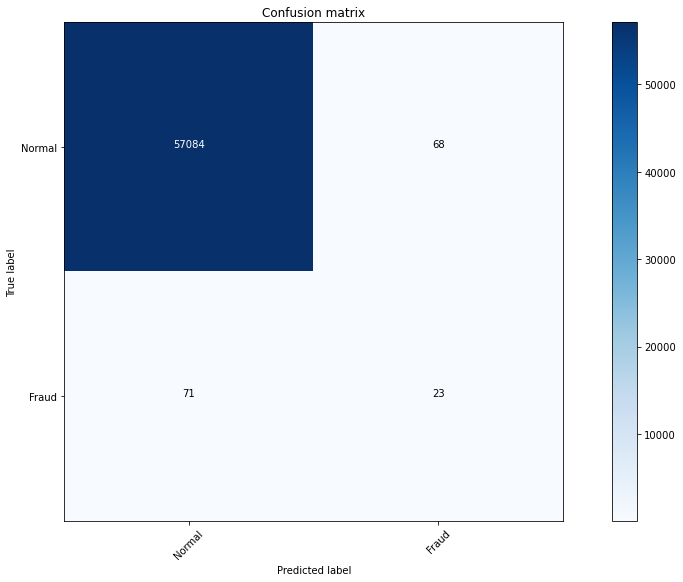

In [38]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])

In [39]:
print('Total fraudulent transactions detected in training set: ' + str(cm_train[1][1]) + ' / ' + str(cm_train[1][1]+cm_train[1][0]))
print('Total non-fraudulent transactions detected in training set: ' + str(cm_train[0][0]) + ' / ' + str(cm_train[0][1]+cm_train[0][0]))

print('Probability to detect a fraudulent transaction in the training set: ' + str(cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])))
print('Probability to detect a non-fraudulent transaction in the training set: ' + str(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])))

print("Accuracy of unsupervised anomaly detection model on the training set: "+str(100*(cm_train[0][0]+cm_train[1][1]) / (sum(cm_train[0]) + sum(cm_train[1]))) + "%")

Total fraudulent transactions detected in training set: 23 / 94
Total non-fraudulent transactions detected in training set: 57084 / 57152
Probability to detect a fraudulent transaction in the training set: 0.24468085106382978
Probability to detect a non-fraudulent transaction in the training set: 0.9988101903695409
Accuracy of unsupervised anomaly detection model on the training set: 99.75718827516333%


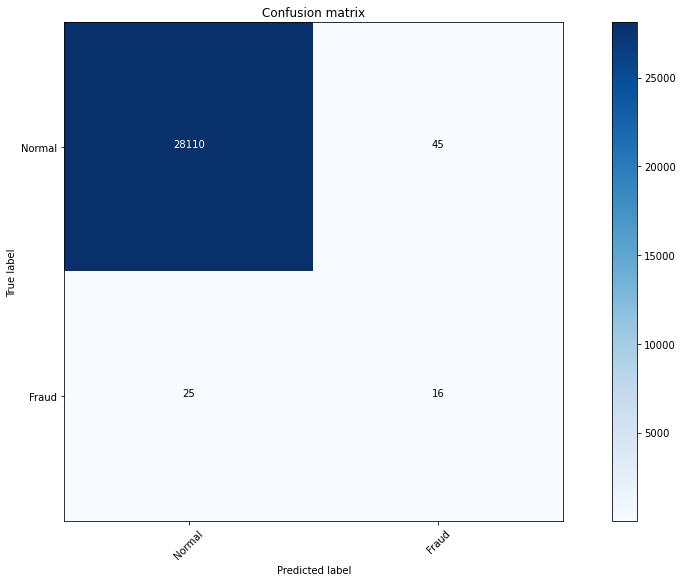

In [40]:
cm_test = confusion_matrix( y_test,y_test_pred)
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

In [41]:
print('Total fraudulent transactions detected in test set: ' + str(cm_test[1][1]) + ' / ' + str(cm_test[1][1]+cm_test[1][0]))
print('Total non-fraudulent transactions detected in test set: ' + str(cm_test[0][0]) + ' / ' + str(cm_test[0][1]+cm_test[0][0]))

print('Probability to detect a fraudulent transaction in the test set: ' + str(cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])))
print('Probability to detect a non-fraudulent transaction in the test set: ' + str(cm_test[0][0]/(cm_test[0][1]+cm_test[0][0])))

print("Accuracy of unsupervised anomaly detection model on the test set: "+str(100*(cm_test[0][0]+cm_test[1][1]) / (sum(cm_test[0]) + sum(cm_test[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_test_pred)))

Total fraudulent transactions detected in test set: 16 / 41
Total non-fraudulent transactions detected in test set: 28110 / 28155
Probability to detect a fraudulent transaction in the test set: 0.3902439024390244
Probability to detect a non-fraudulent transaction in the test set: 0.9984017048481619
Accuracy of unsupervised anomaly detection model on the test set: 99.75173783515392%
ROC_AUC_score : 0.694323


In [42]:
print(classification_report(y_test,y_test_pred))  # f1 - score - 0.35 - BAd

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28155
           1       0.26      0.39      0.31        41

    accuracy                           1.00     28196
   macro avg       0.63      0.69      0.66     28196
weighted avg       1.00      1.00      1.00     28196



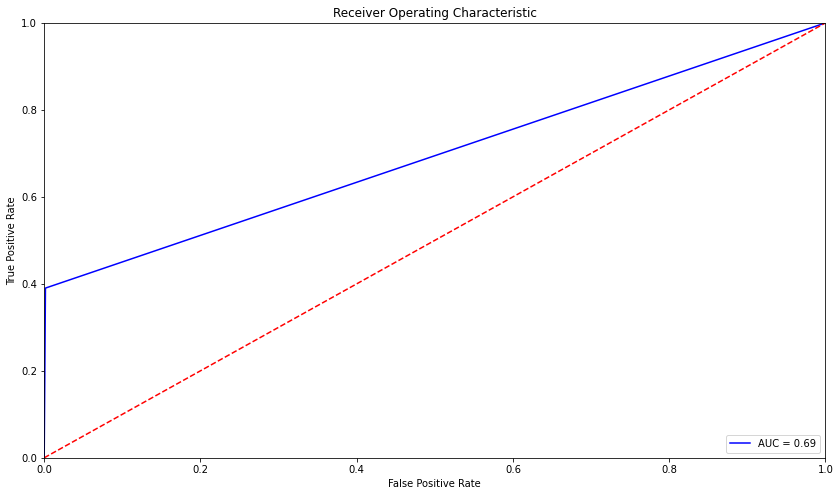

In [43]:
plot_roc(y_test,y_test_pred)

In [82]:
predicts["Isolation Forest"] = y_test_pred

The results we've got through this model are far from ideal. We have not been able to classify fraudulent transactions efficiently despite having a high accuracy (which is not a good metric to measure performance on a skewed dataset anyways). Supervised learning for anomaly detection is the move fot this dataset since we have the labels. One reason why unsupervised learning did not perform well enough is because most of the fraudulent transactions did not have much unusual characteristics regarding them which can be well separated from normal transactions and I feel that's the main reason they provided us with a labelled dataset. Anyways, this notebook represents how unsupervised learning captures anomalies. The accuracy of detecting anomalies on the test set is 25%, which is way better than a random guess (the fraction of anomalies in the dataset is < 0.1%). I have also implemented the supervised learning model for this dataset, which works extremely well.

## Supervised SVM

In [72]:
from sklearn import preprocessing, svm
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [73]:
predictions = classifier.predict(X_test)

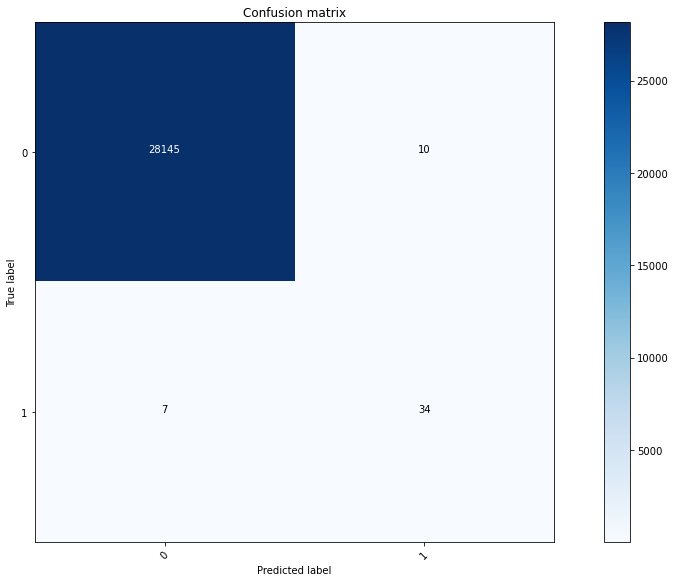

In [74]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [75]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Logistic Regression model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 34 / 41
Total non-fraudulent transactions detected: 28145 / 28155
Probability to detect a fraudulent transaction: 0.8292682926829268
Probability to detect a non-fraudulent transaction: 0.9996448232995916
Accuracy of the Logistic Regression model : 99.93970775996596%
ROC_AUC_score : 0.914457


In [76]:
print(classification_report(y_test,predictions))   # f1 - score - 0.83 the second best after ANN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28155
           1       0.77      0.83      0.80        41

    accuracy                           1.00     28196
   macro avg       0.89      0.91      0.90     28196
weighted avg       1.00      1.00      1.00     28196



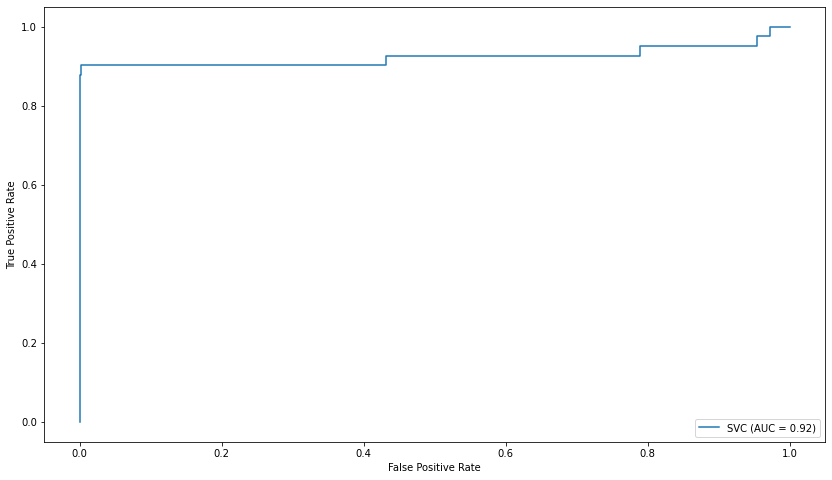

In [77]:
plot_roc_curve(classifier,X_test,y_test)

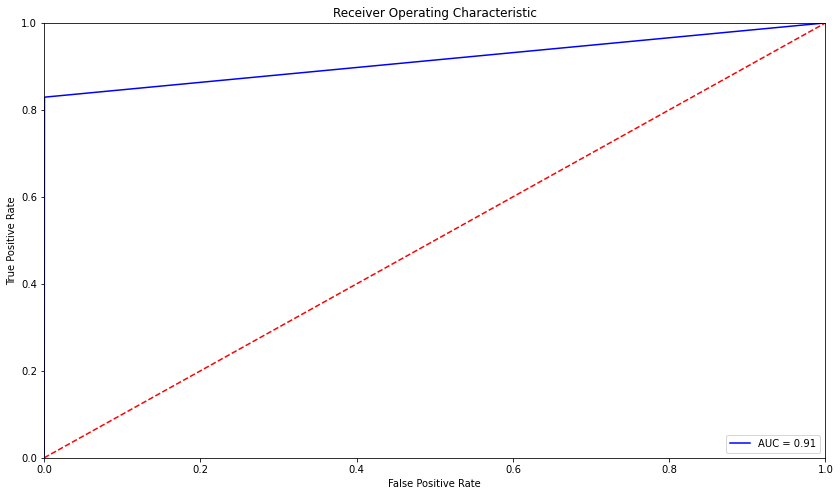

In [78]:
plot_roc(y_test,predictions)

In [79]:
predicts["SVM"] = predictions

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [45]:
predictions = classifier.predict(X_test)

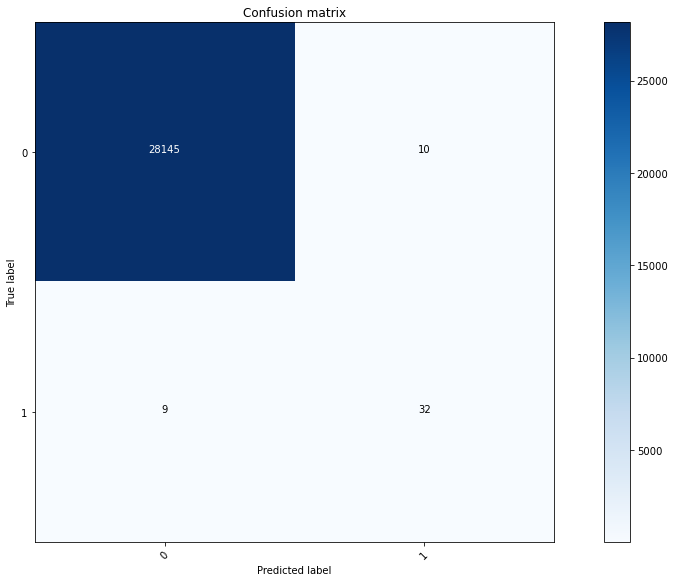

In [46]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [47]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Logistic Regression model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 32 / 41
Total non-fraudulent transactions detected: 28145 / 28155
Probability to detect a fraudulent transaction: 0.7804878048780488
Probability to detect a non-fraudulent transaction: 0.9996448232995916
Accuracy of the Logistic Regression model : 99.93261455525607%
ROC_AUC_score : 0.890066


In [48]:
print(classification_report(y_test,predictions))  # f1 - score - 0.68 the best among all

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28155
           1       0.76      0.78      0.77        41

    accuracy                           1.00     28196
   macro avg       0.88      0.89      0.89     28196
weighted avg       1.00      1.00      1.00     28196



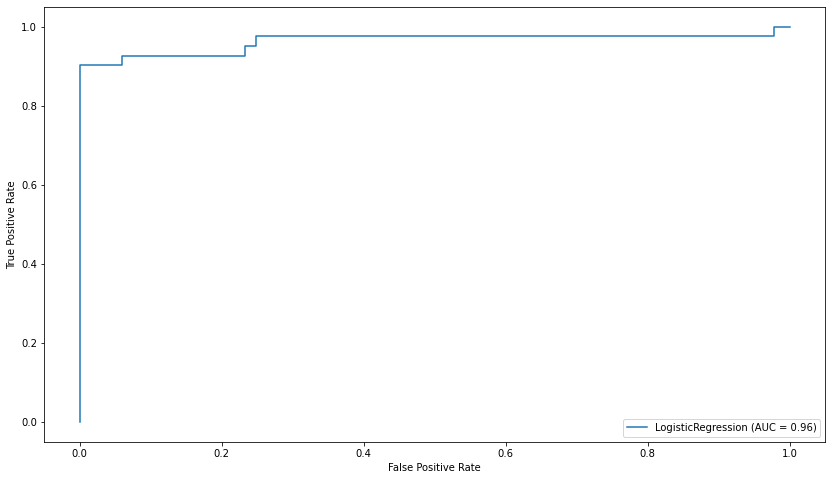

In [49]:
plot_roc_curve(classifier,X_test,y_test)

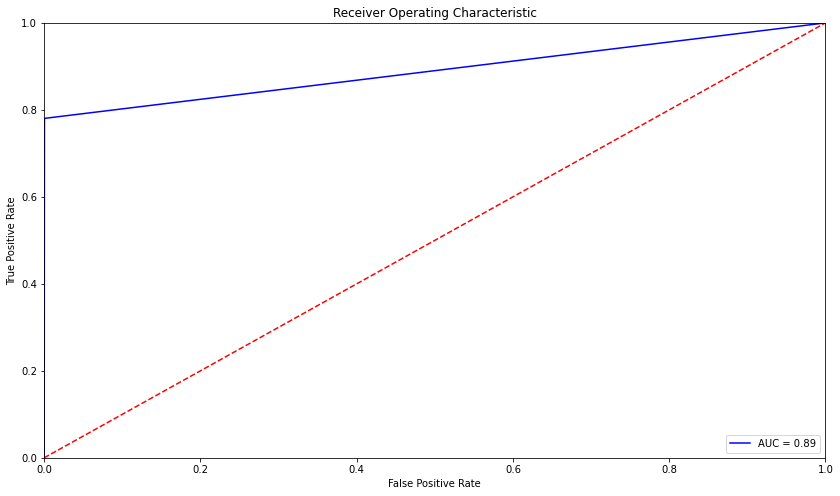

In [50]:
plot_roc(y_test,predictions)

In [51]:
predicts["Logistic Regression"] = predictions

## Multivariate Gaussian Anomaly detection

The intuition behind applying this technique in our case;-

It is preferred over Supervised Learning Algorithms when there are very small positive examples (y=1) compared to large negative examples (y=0) which makes it ideal for our case due to high-class imbalance nature of our Dataset.

Since credit card fraud in the future may be completely different, it gives us the liberty of classifying different types of anomalies. In contrast to other classification algorithms which demand future examples similar to training ones.

The features provided to us are already gone through PCA meaning independent of each other thus satisfying the prerequisite of this technique

In [87]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V25,V26,V27,V28,Amount,Class
169876,-0.611712,-0.769705,-0.149759,-0.224877,2.028577,-2.019887,0.292491,-0.523020,0.358468,0.070050,...,-0.196039,-0.075208,0.045536,0.380739,-2.220686,-0.201146,0.066501,0.221180,1.79,0
127467,-0.814682,1.319219,1.329415,0.027273,-0.284871,-0.653985,0.321552,0.435975,-0.704298,-0.600684,...,-0.009041,-0.128619,-0.368565,0.090660,-0.261034,0.080621,0.162427,0.059456,1.98,0
137900,-0.318193,1.118618,0.969864,-0.127052,0.569563,-0.532484,0.706252,-0.064966,-0.463271,-0.528357,...,0.206028,-0.305402,-0.774704,-0.123884,-0.018148,0.121679,0.249050,0.092516,0.89,0
21513,-1.328271,1.018378,1.775426,-1.574193,-0.117696,-0.457733,0.681867,-0.031641,0.383872,0.334853,...,0.315823,-0.220815,-0.419013,-0.239197,0.232829,0.814177,0.098797,-0.004273,15.98,0
134700,1.276712,0.617120,-0.578014,0.879173,0.061706,-1.472002,0.373692,-0.287204,-0.084482,-0.696578,...,-0.105286,-0.160161,-0.430404,-0.076738,0.552170,0.370701,-0.034255,0.041709,0.76,0


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    # print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

print("df shape", df.shape)
print("original_Xtrain shape", original_Xtrain.shape)
print("original_ytrain shape", original_ytrain.shape)
print("original_Xtest shape", original_Xtest.shape)
print("original_ytest shape", original_ytest.shape)

df shape (85442, 29)
original_Xtrain shape (68354, 28)
original_ytrain shape (68354,)
original_Xtest shape (17088, 28)
original_ytest shape (17088,)


In [89]:
# Make Dataset

credit_card_4_5 = pd.concat([pd.DataFrame(original_Xtrain), pd.DataFrame(original_ytrain)], axis=1)
credit_card_1_5 = pd.concat([pd.DataFrame(original_Xtest), pd.DataFrame(original_ytest)], axis=1)

In [90]:
credit_card_1_5.to_csv("credit_card_1_5.csv")
credit_card_4_5.to_csv("credit_card_4_5.csv")

In [91]:
print("credit_card_4_5 -> ", credit_card_4_5.shape)
print("credit_card_1_5 -> ", credit_card_1_5.shape)

credit_card_4_5 ->  (68354, 29)
credit_card_1_5 ->  (17088, 29)


In [93]:
df = credit_card_4_5

In [94]:
from scipy.stats import multivariate_normal

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariateGaussian(dataset, mu, sigma):
    p = multivariate_normal(mean = mu, cov = sigma)
    return p.pdf(dataset)

In [95]:
# below which we will mark transaction as Anomalous.

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    farray = []
    Recallarray = []
    Precisionarray = []
    epsilons = (0.0000e+00, 1.0527717316e-70, 1.0527717316e-50, 1.0527717316e-24)
    for epsilon in epsilons:
        predictions = (p_cv < epsilon)
        f = f1_score(train_cv_y, predictions, average = "binary")
        Recall = recall_score(train_cv_y, predictions, average = "binary")
        Precision = precision_score(train_cv_y, predictions, average = "binary")
        farray.append(f)
        Recallarray.append(Recall)
        Precisionarray.append(Precision)
        print ('For below Epsilon')
        print(epsilon)
        print ('F1 score , Recall and Precision are as below')
        print ('Best F1 Score %f' %f)
        print ('Best Recall Score %f' %Recall)
        print ('Best Precision Score %f' %Precision)
        print ('-'*40)
        if f > best_f1:
            best_f1 = f
            best_recall = Recall
            best_precision = Precision
            best_epsilon = epsilon    
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.7, 0.3])
    #plt.subplot(3,1,1)
    plt.plot(farray ,"ro")
    plt.plot(farray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('F1 score vs Epsilon value')
    ax.annotate('Best F1 Score', xy=(best_epsilon,best_f1), xytext=(best_epsilon,best_f1))
    plt.xlabel("Epsilon value") 
    plt.ylabel("F1 Score") 
    plt.show()
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    #plt.subplot(3,1,2)
    plt.plot(Recallarray ,"ro")
    plt.plot(Recallarray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('Recall vs Epsilon value')
    ax.annotate('Best Recall Score', xy=(best_epsilon,best_recall), xytext=(best_epsilon,best_recall))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Recall Score") 
    plt.show()
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    #plt.subplot(3,1,3)
    plt.plot(Precisionarray ,"ro")
    plt.plot(Precisionarray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('Precision vs Epsilon value')
    ax.annotate('Best Precision Score', xy=(best_epsilon,best_precision), xytext=(best_epsilon,best_precision))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Precision Score") 
    plt.show()
    return best_f1, best_epsilon

In [96]:
train_strip_v1 = df[df["Class"] == 1]
train_strip_v0 = df[df["Class"] == 0]

In [97]:
Normal_len = len (train_strip_v0)
Anomolous_len = len (train_strip_v1)

start_mid = Anomolous_len // 2
start_midway = start_mid + 1

train_cv_v1  = train_strip_v1 [: start_mid]
train_test_v1 = train_strip_v1 [start_midway:Anomolous_len]

start_mid = (Normal_len * 60) // 100
start_midway = start_mid + 1

cv_mid = (Normal_len * 80) // 100
cv_midway = cv_mid + 1

train_fraud = train_strip_v0 [:start_mid]
train_cv    = train_strip_v0 [start_midway:cv_mid]
train_test  = train_strip_v0 [cv_midway:Normal_len]

train_cv = pd.concat([train_cv,train_cv_v1],axis=0)
train_test = pd.concat([train_test,train_test_v1],axis=0)

train_cv_y = train_cv["Class"]
train_test_y = train_test["Class"]

train_cv.drop(labels = ["Class"], axis = 1, inplace = True)
train_fraud.drop(labels = ["Class"], axis = 1, inplace = True)
train_test.drop(labels = ["Class"], axis = 1, inplace = True)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [98]:
# Finding Probabilities

mu, sigma = estimateGaussian(train_fraud)
p = multivariateGaussian(train_fraud,mu,sigma)
p_cv = multivariateGaussian(train_cv,mu,sigma)
p_test = multivariateGaussian(train_test,mu,sigma)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For below Epsilon
0.0
F1 score , Recall and Precision are as below
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-70
F1 score , Recall and Precision are as below
Best F1 Score 0.418367
Best Recall Score 0.759259
Best Precision Score 0.288732
----------------------------------------
For below Epsilon
1.0527717316e-50
F1 score , Recall and Precision are as below
Best F1 Score 0.325581
Best Recall Score 0.777778
Best Precision Score 0.205882
----------------------------------------
For below Epsilon
1.0527717316e-24
F1 score , Recall and Precision are as below
Best F1 Score 0.123198
Best Recall Score 0.870370
Best Precision Score 0.066291
----------------------------------------


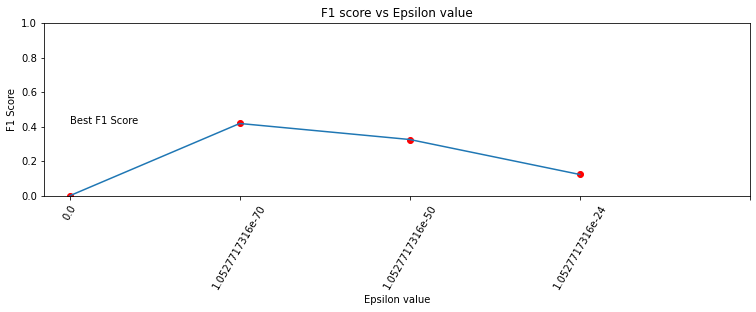

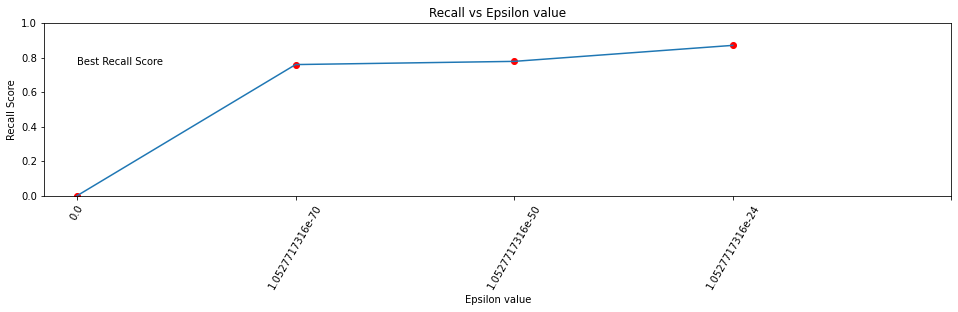

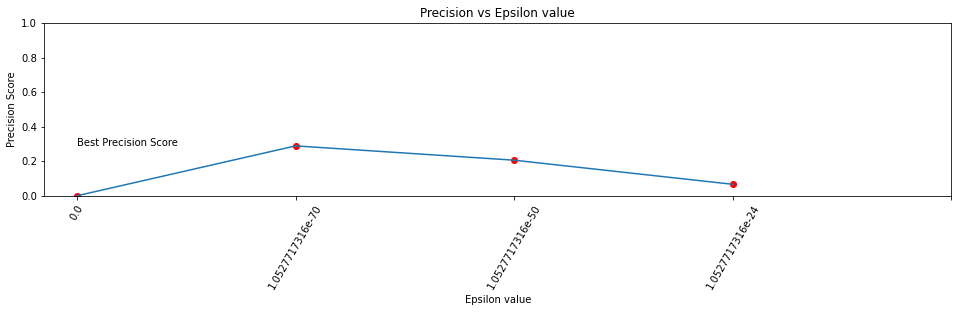

In [99]:
# Performance wrt to Epsilon values
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score , average_precision_score
from sklearn.metrics import precision_score, precision_recall_curve

fscore, ep= selectThresholdByCV(p_cv,train_cv_y)

In [100]:
print("PREDICTIONS ON CROSS-VALIDATION SET\n")
predictions = (p_cv < ep)
Recall = recall_score(train_cv_y, predictions, average = "binary")    
Precision = precision_score(train_cv_y, predictions, average = "binary")
F1score = f1_score(train_cv_y, predictions, average = "binary")    
print ('F1 score , Recall and Precision for Cross Validation dataset')
print ('Best F1 Score %f' %F1score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

PREDICTIONS ON CROSS-VALIDATION SET

F1 score , Recall and Precision for Cross Validation dataset
Best F1 Score 0.418367
Best Recall Score 0.759259
Best Precision Score 0.288732


In [101]:
print("PREDICTIONS ON TEST SET\n")
predictions = (p_test < ep)
Recall = recall_score(train_test_y, predictions, average = "binary")    
Precision = precision_score(train_test_y, predictions, average = "binary")
F1score = f1_score(train_test_y, predictions, average = "binary")    
print ('F1 score , Recall and Precision for Test dataset')
print ('Best F1 Score %f' %F1score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

PREDICTIONS ON TEST SET

F1 score , Recall and Precision for Test dataset
Best F1 Score 0.391960
Best Recall Score 0.735849
Best Precision Score 0.267123


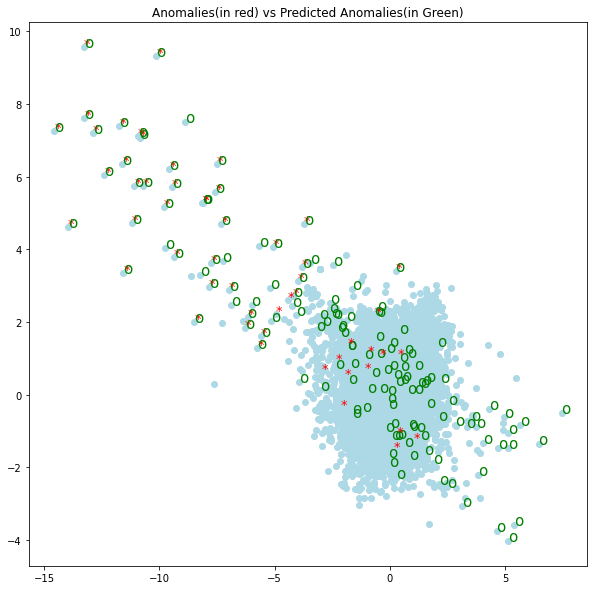

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(train_test['V14'],train_test['V11'],marker="o", color="lightBlue")
ax.set_title('Anomalies(in red) vs Predicted Anomalies(in Green)')
for i, txt in enumerate(train_test['V14'].index):
       if train_test_y.loc[txt] == 1 :
            ax.annotate('*', (train_test['V14'].loc[txt],train_test['V11'].loc[txt]),fontsize=13,color='Red')
       if predictions[i] == True :
            ax.annotate('o', (train_test['V14'].loc[txt],train_test['V11'].loc[txt]),fontsize=15,color='Green')

In [103]:
test_df = credit_card_1_5

In [106]:
test_y = test_df['Class']

In [107]:
test_df.drop(labels = ["Class"], axis = 1, inplace = True)

In [108]:
p_test_df = multivariateGaussian(test_df,mu,sigma)


In [109]:
print("PREDICTIONS ON ORIGINAL TEST SET\n")
predictions = (p_test_df < ep)
Recall = recall_score(test_y, predictions, average = "binary")    
Precision = precision_score(test_y, predictions, average = "binary")
F1score = f1_score(test_y, predictions, average = "binary")    
print ('F1 score , Recall and Precision for Test dataset')
print ('Best F1 Score %f' %F1score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

PREDICTIONS ON ORIGINAL TEST SET

F1 score , Recall and Precision for Test dataset
Best F1 Score 0.238636
Best Recall Score 0.777778
Best Precision Score 0.140940


In [114]:
predicts["Gaussian Anomaly Detection"] = predictions
del predicts["Gaussian Anomaly Detection"] 

In [115]:
print(predictions.shape)
print(y_test.shape)

(17088,)
(28196,)


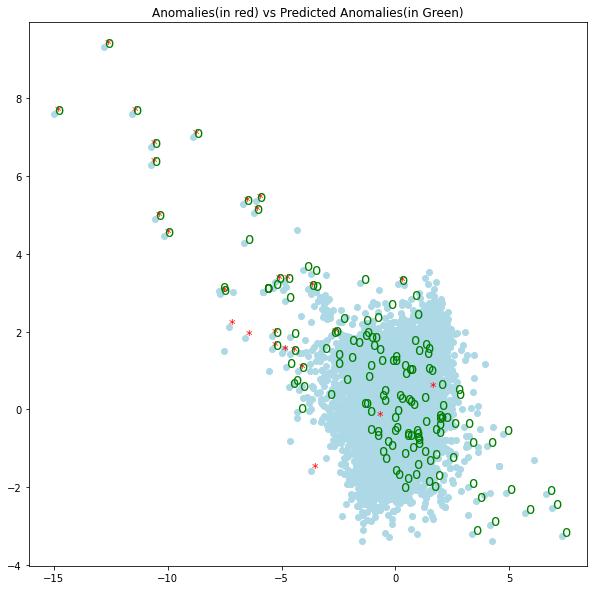

In [111]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(test_df['V14'],test_df['V11'],marker="o", color="lightBlue")
ax.set_title('Anomalies(in red) vs Predicted Anomalies(in Green)')
for i, txt in enumerate(test_df['V14'].index):
       if test_y.loc[txt] == 1 :
            ax.annotate('*', (test_df['V14'].loc[txt],test_df['V11'].loc[txt]),fontsize=13,color='Red')
       if predictions[i] == True :
            ax.annotate('o', (test_df['V14'].loc[txt],test_df['V11'].loc[txt]),fontsize=15,color='Green')

[[16933   128]
 [    6    21]]
Accuracy for Gaussian Anomaly Detection:  99.21582397003745
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     17061
           1       0.14      0.78      0.24        27

    accuracy                           0.99     17088
   macro avg       0.57      0.89      0.62     17088
weighted avg       1.00      0.99      0.99     17088

Total number of Transactions classified as Fraudulent:  149
Number of Fraudulent Transactions classified as Non-fraudulent:  6 out of 98


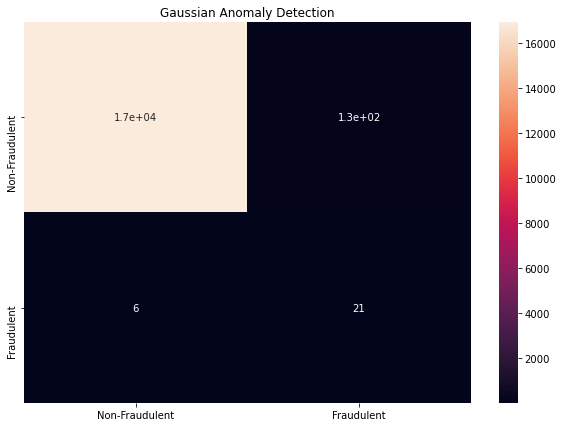

In [112]:
import seaborn as sn
mat = confusion_matrix(test_y,predictions)
print(mat)
print("Accuracy for Gaussian Anomaly Detection: ", accuracy_score(test_y,predictions)*100)
print(classification_report(test_y,predictions))
print("Total number of Transactions classified as Fraudulent: ", mat[1][1]+mat[0][1])
print("Number of Fraudulent Transactions classified as Non-fraudulent: ", mat[1][0], "out of 98")
df_cm = pd.DataFrame(confusion_matrix(test_y,predictions), index = [i for i in ['Non-Fraudulent','Fraudulent']],
                  columns = [i for i in ['Non-Fraudulent','Fraudulent']])
plt.figure(figsize = (10,7))
plt.title("Gaussian Anomaly Detection")
sn.heatmap(df_cm, annot=True)

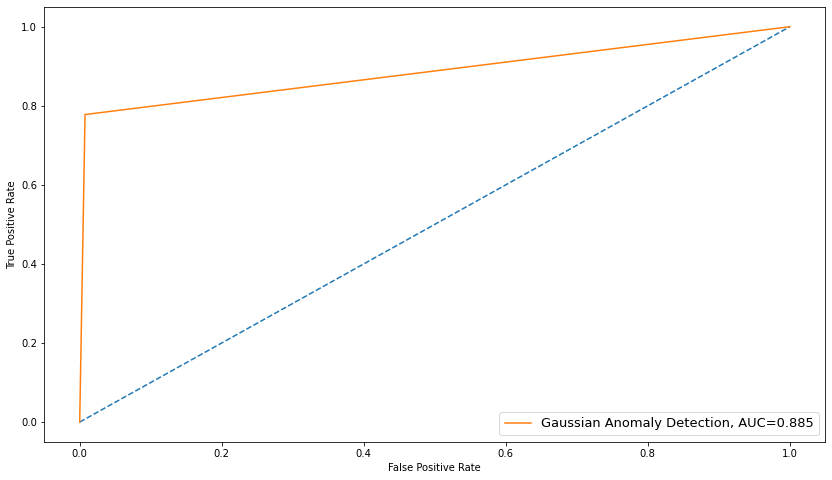

In [117]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_y, predictions)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr,label = "{}, AUC={:.3f}".format("Gaussian Anomaly Detection", roc_auc_score(test_y,predictions)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(prop={'size':13}, loc='lower right')
name = 'ROC curve for Anomaly Detection'

## Classification Using Neural Networks

In [52]:
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [53]:
X_train.shape

(57246, 28)

In [54]:
# Building our model with 2 hidden layers
model = Sequential()
model.add(Dense(32,kernel_initializer = 'he_uniform', input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, kernel_initializer = 'he_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'glorot_uniform',activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)


Epoch 1/10
5725/5725 [==============================] - 9s 1ms/step - loss: 0.0638 - accuracy: 0.9984
Epoch 2/10
5725/5725 [==============================] - 9s 2ms/step - loss: 0.0304 - accuracy: 0.9988
Epoch 3/10
5725/5725 [==============================] - 10s 2ms/step - loss: 0.0261 - accuracy: 0.9987
Epoch 4/10
5725/5725 [==============================] - 9s 2ms/step - loss: 0.0153 - accuracy: 0.9990
Epoch 5/10
5725/5725 [==============================] - 9s 2ms/step - loss: 0.0155 - accuracy: 0.9990
Epoch 6/10
5725/5725 [==============================] - 9s 2ms/step - loss: 0.0100 - accuracy: 0.9990
Epoch 7/10
5725/5725 [==============================] - 9s 2ms/step - loss: 0.0071 - accuracy: 0.9990
Epoch 8/10
5725/5725 [==============================] - 9s 2ms/step - loss: 0.0087 - accuracy: 0.9993
Epoch 9/10
5725/5725 [==============================] - 9s 2ms/step - loss: 0.0056 - accuracy: 0.9993
Epoch 10/10
5725/5725 [==============================] - 9s 2ms/step - loss: 0.00

In [55]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

882/882 [==============================] - 1s 1ms/step - loss: 0.0058 - accuracy: 0.9994
Accuracy: 99.94


In [56]:
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
rounded = [round(x[0]) for x in predictions]
rounded = np.array(rounded)
rounded.shape

(28196,)

In [57]:
# make class predictions with the model
predictions = model.predict_classes(X_test)
predictions.shape

(28196, 1)

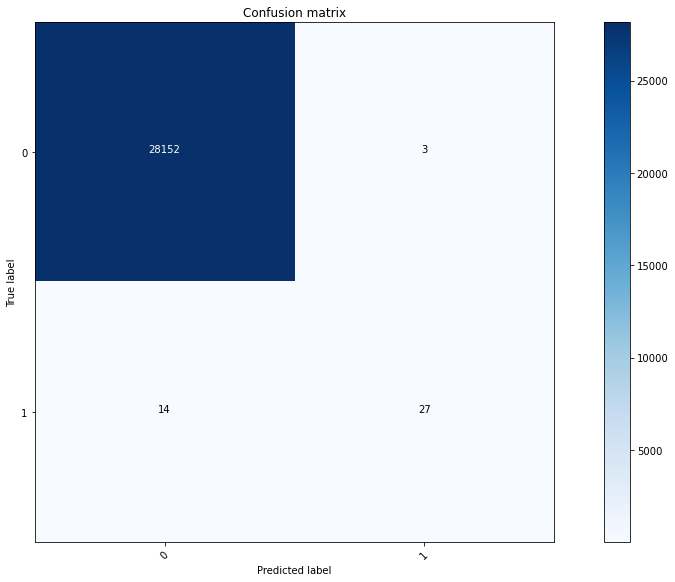

In [58]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [59]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Neural Network model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 27 / 41
Total non-fraudulent transactions detected: 28152 / 28155
Probability to detect a fraudulent transaction: 0.6585365853658537
Probability to detect a non-fraudulent transaction: 0.9998934469898775
Accuracy of the Neural Network model : 99.93970775996596%
ROC_AUC_score : 0.829215


In [60]:
print(classification_report(y_test,predictions))   # f1 - score - 0.80 the best among all

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28155
           1       0.90      0.66      0.76        41

    accuracy                           1.00     28196
   macro avg       0.95      0.83      0.88     28196
weighted avg       1.00      1.00      1.00     28196



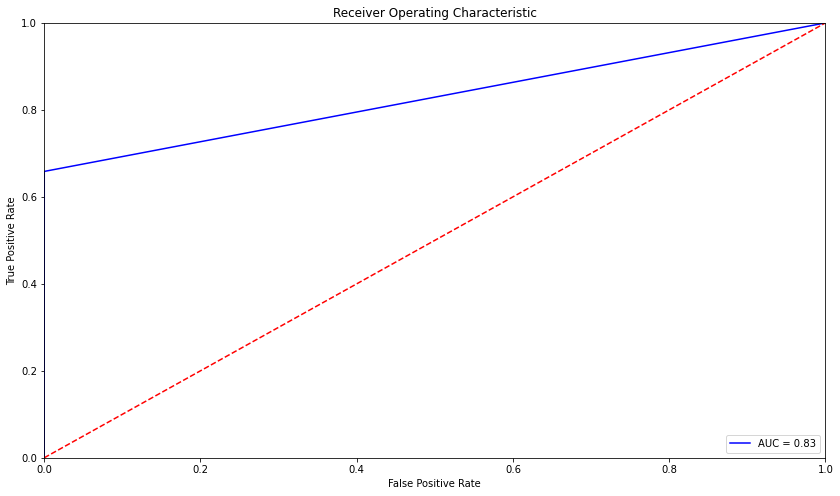

In [61]:
plot_roc(y_test,predictions)

In [63]:
predicts["ANN"] = predictions

In [ ]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Neural Network model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

In [ ]:
print(classification_report(y_test,predictions))   # f1 - score - 0.84 the best among all

### ANN has shown decrease in F1 score on oversampled data

# Random Forest 

In [64]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [65]:
model.fit(X_train,y_train)

RandomForestClassifier()

In [66]:
predictions = model.predict(X_test)

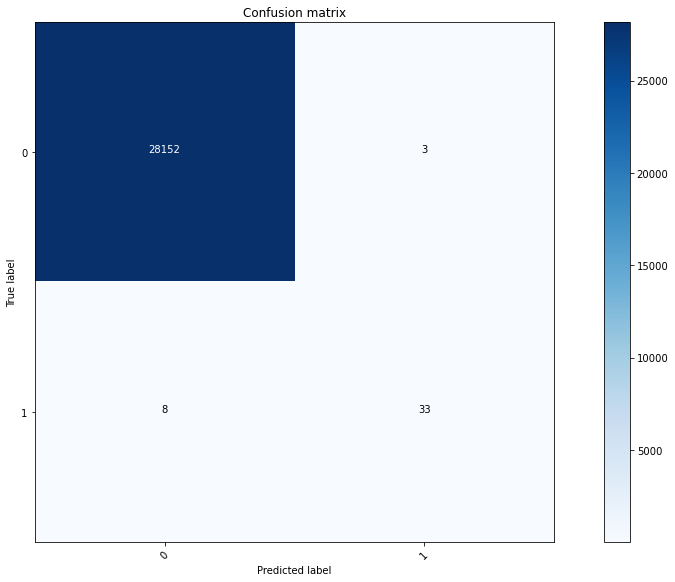

In [67]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [68]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Random Forest model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 33 / 41
Total non-fraudulent transactions detected: 28152 / 28155
Probability to detect a fraudulent transaction: 0.8048780487804879
Probability to detect a non-fraudulent transaction: 0.9998934469898775
Accuracy of the Random Forest model : 99.96098737409562%
ROC_AUC_score : 0.902386


In [69]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28155
           1       0.92      0.80      0.86        41

    accuracy                           1.00     28196
   macro avg       0.96      0.90      0.93     28196
weighted avg       1.00      1.00      1.00     28196



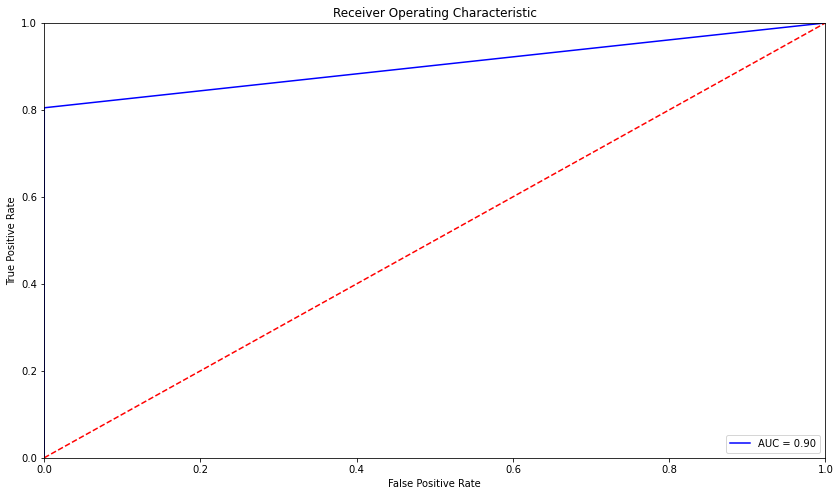

In [70]:
plot_roc(y_test,predictions)

In [71]:
predicts["Random Forest"] = predictions

In [ ]:
print(classification_report(y_test,predictions))  # F1 - score - 0.85

# Plotting combined ROC curve for all in one

In [121]:
for key in predicts.keys():
     print(key)

Logistic Regression
ANN
Random Forest
SVM
Isolation Forest
Gaussian Anomaly Detection


ValueError: Found input variables with inconsistent numbers of samples: [28196, 17088]

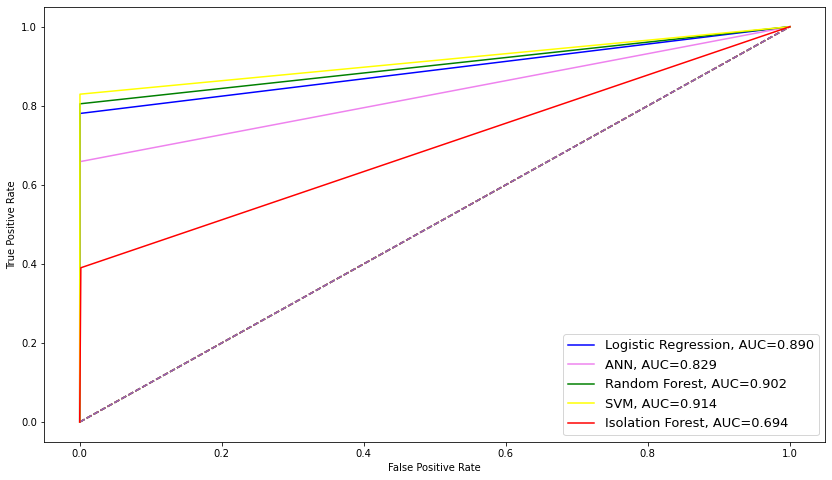

In [120]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
colour={"Isolation Forest": 'red',
       "Logistic Regression": 'blue',
       "Random Forest" : 'green',
      #  "Sequential": 'p-',
        "SVM": 'yellow',
        "ANN": 'violet',
       # "Genetic Algorithm": 'o-'
        }
for key in predicts.keys():
    fpr, tpr, thresholds = roc_curve(y_test, predicts[key])
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr,colour[key],label = "{}, AUC={:.3f}".format(key, roc_auc_score(y_test,predicts[key])))
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    plt.legend(prop={'size':13}, loc='lower right')
    #name = 'ROC curve for '+key